# Creating coordinates labels as masks for UNet

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from wings.config import COUNTRIES, RAW_DATA_DIR
from wings.dataset import WingsDataset
from wings.visualizing.image_preprocess import denormalize, unet_preprocess
from wings.visualizing.visualize import visualize_coords

dataset = WingsDataset(COUNTRIES, RAW_DATA_DIR, unet_preprocess)
max_n = len(dataset)

2025-05-29 14:09:22.528 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-05-29 14:09:22.623 | INFO     | wings.config:<module>:62 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'
100%|██████████| 21722/21722 [00:00<00:00, 82205.27it/s] 


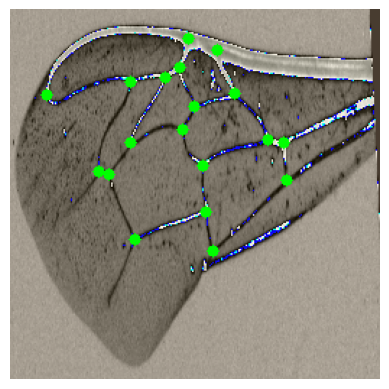

In [2]:
n = np.random.randint(0, max_n)
image, labels = dataset[n]
w, h = image.shape[2], image.shape[1]
x_coords, y_coords = labels[::2].int(), labels[1::2].int()
y_coords = h - y_coords - 1
img = image
img = denormalize(img)

visualize_coords(img, labels.squeeze(0), spot_size=4)

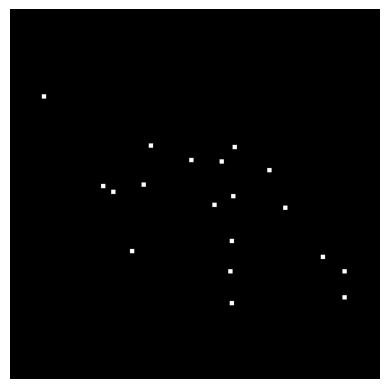

In [3]:
import numpy as np

n = np.random.randint(0, max_n)
image, labels = dataset[n]
w, h = image.shape[2], image.shape[1]
x_coords, y_coords = labels[::2].int(), labels[1::2].int()
y_coords = h - y_coords - 1

img_size = 256
square_size = 3

mask = np.zeros((img_size, img_size), dtype=np.float32)

square_half = square_size // 2
for x, y in zip(x_coords, y_coords):
    x, y = int(x), int(y)
    x_start = max(0, x - square_half)
    x_end = min(img_size, x + square_half + 1)
    y_start = max(0, y - square_half)
    y_end = min(img_size, y + square_half + 1)

    mask[y_start:y_end, x_start:x_end] = 1

mask = torch.from_numpy(mask).unsqueeze(0)
plt.imshow(mask.squeeze(), cmap='gray')
plt.axis('off')
plt.show()


In [4]:
from wings.config import EXTERNAL_DATA_DIR
from skimage.io import imread

mask = imread(EXTERNAL_DATA_DIR / 'test_unet_mask.tif', as_gray=True)
print(f"{mask.shape=}")
print(f"{type(mask)=}")
print(f"{mask.dtype=}")
print(f"{mask.min()=}\t{mask.max()=}")
print(mask)

mask.shape=(256, 256)
type(mask)=<class 'numpy.ndarray'>
mask.dtype=dtype('uint8')
mask.min()=np.uint8(0)	mask.max()=np.uint8(255)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
import torch

model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch',
    'unet',
    in_channels=3,
    out_channels=1,
    init_features=32,
    pretrained=True
)

Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [6]:
import urllib

url, filename = (
    "https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
try:
    urllib.URLopener().retrieve(url, filename)
except:
    urllib.request.urlretrieve(url, filename)


(256, 256)
float32


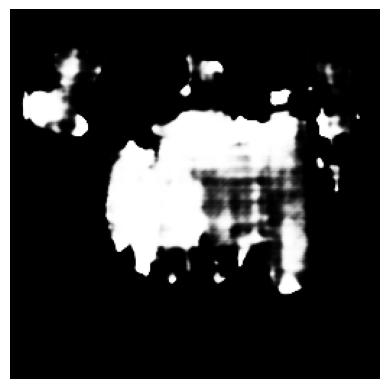

In [7]:
import numpy as np
from PIL import Image
from torchvision import transforms

input_image = Image.open(filename)
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=m, std=s),
    ]
)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

mask_2d = output.squeeze()
# mask_2d = torch.round(output).squeeze()
mask_np = mask_2d.cpu().numpy()
print(mask_np.shape)
print(mask_np.dtype)
# Step 3: Display it
plt.imshow(mask_np, cmap='gray')
plt.axis('off')  # Optional: Hide axis
plt.show()

In [8]:
from wings.dataset import MasksDataset

square_size = 3
unet_dataset = MasksDataset(COUNTRIES, RAW_DATA_DIR, unet_preprocess, square_size=square_size)
max_n = len(unet_dataset)

100%|██████████| 21722/21722 [00:00<00:00, 107601.38it/s]


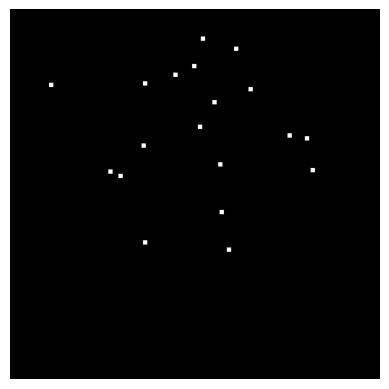

In [10]:
n = np.random.randint(0, max_n)
image, mask, labels, orig_size = unet_dataset[n]

plt.imshow(mask.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')  # Optional: Hide axis
plt.show()

[]

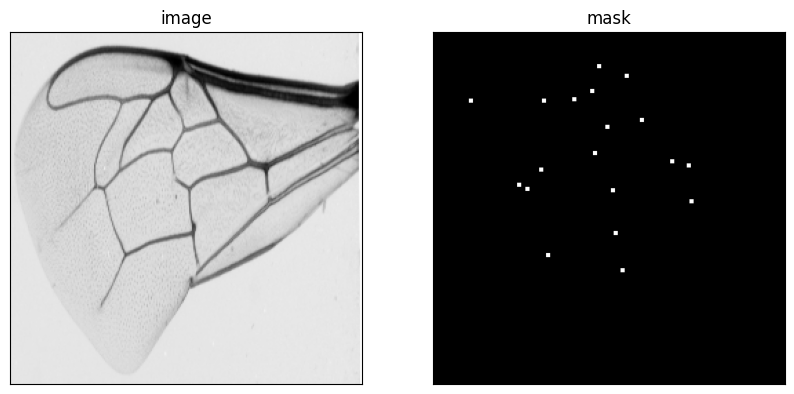

In [12]:
from wings.config import IMG_FOLDER_SUFX
from torchvision.io import decode_image
import torchvision.transforms.functional as F

n = np.random.randint(0, max_n)
_, mask, _, _ = unet_dataset[n]
filename = unet_dataset.coords_df.loc[n, 'file']
country = filename.split('-', 1)[0]
img = decode_image(str(RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename))
img = F.resize(img, [256, 256], interpolation=F.InterpolationMode.BILINEAR, antialias=False)
img = img.numpy().transpose(1, 2, 0)
# img = np.ascontiguousarray(img)


_, ax = plt.subplots(1, 2, figsize=(10, 10))
mask = mask.squeeze().cpu().numpy()
ax[0].imshow(img, cmap="gray")
ax[0].set_title("image")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("mask")
ax[1].set_xticks([])
ax[1].set_yticks([])

(256, 256, 3)


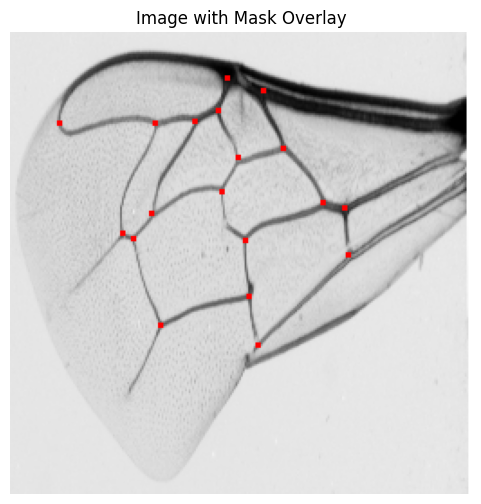

In [13]:
import cv2

image_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
print(image_bgr.shape)

# Create boolean mask for white pixels in mask
white_areas = mask == 1

# Set those areas to red (BGR: [0, 0, 255])
image_bgr[white_areas] = [0, 0, 255]

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show the result
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Image with Mask Overlay")
plt.show()

In [15]:
n = np.random.randint(0, max_n)
image, mask, labels, orig_size = unet_dataset[n]
print(image.shape)
image = image.unsqueeze(0)
print(image.shape)
image = image.to('cuda')
with torch.no_grad():
    output = model(image)

torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])


(256, 256)
float32


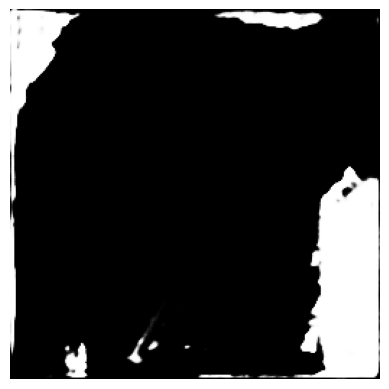

In [16]:
mask_2d = output.squeeze()
# mask_2d = torch.round(output).squeeze()
mask_np = mask_2d.cpu().numpy()
print(mask_np.shape)
print(mask_np.dtype)
# Step 3: Display it
plt.imshow(mask_np, cmap='gray')
plt.axis('off')  # Optional: Hide axis
plt.show()
